In [2]:
import change_path

import tf_memory_limit
import atacseq
import datagen
import evaluation_tools
import pandas as pd
import numpy as np

import pickle
import matplotlib.pyplot as plt
from keras.models import load_model

['', '/usr/lib/python35.zip', '/usr/lib/python3.5', '/usr/lib/python3.5/plat-x86_64-linux-gnu', '/usr/lib/python3.5/lib-dynload', '/home/kal/VENV/lib/python3.5/site-packages/', '/home/kal/VENV/lib64/python3.5/site-packages/', '/home/kal/VENV/lib/python3.5/site-packages/IPython/extensions/', '/home/kal/K27act_models/bin/', '/home/kal/TF_models/bin/', '/home/kal/TF_models/bin/']


In [10]:
# load in some data
peaks_path = '/home/kal/K27act_models/GM_data/k27act_training_regions_cg.bed'
peaks = pd.read_table(peaks_path)
peaks['score'] = peaks['k27act']

In [4]:
# load in a model
model = evaluation_tools.ATACmodel('/home/kal/K27act_models/convolution_model/20180711_144600_counts_pwm_sum/')

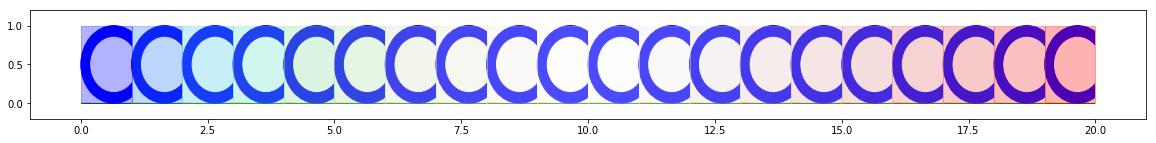

In [11]:
s = atacseq.ATACSeq('c'*20, atac_counts=range(20))
s.logo()

d = datagen.datagen(peaks)

10.973025291270194


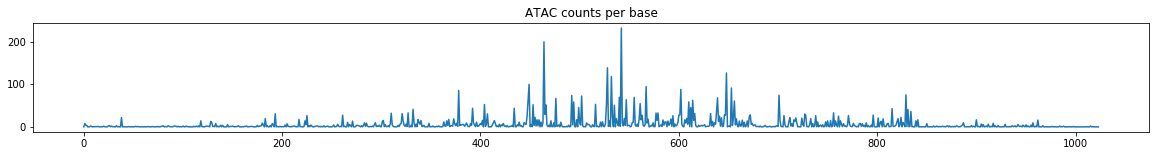

In [22]:
n, s = next(d)
print(s)
seq = atacseq.ATACSeq(n)
seq.graph()

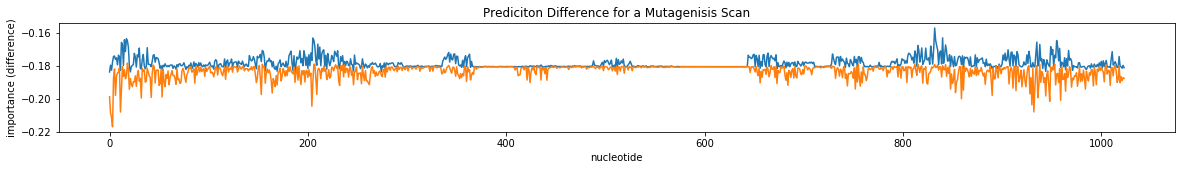

(array([[-0.18347836, -0.19730568, -0.19852066, -0.18868685],
        [-0.1794343 , -0.19203281, -0.20846272, -0.17941809],
        [-0.18242884, -0.19259548, -0.2110219 , -0.18491077],
        ...,
        [-0.18129945, -0.18883133, -0.18606234, -0.18124866],
        [-0.18219543, -0.18694782, -0.17949677, -0.18074417],
        [-0.18249846, -0.18740702, -0.18318582, -0.18089247]],
       dtype=float32),
 array([[ 0.00851965, -0.00530767, -0.00652266,  0.00331116],
        [ 0.01040268, -0.00219584, -0.01862574,  0.01041889],
        [ 0.01031041,  0.00014377, -0.01828265,  0.00782847],
        ...,
        [ 0.00306106, -0.00447083, -0.00170183,  0.00311184],
        [ 0.00015068, -0.00460172,  0.00284934,  0.00160193],
        [ 0.00099754, -0.00391102,  0.00031018,  0.00260353]],
       dtype=float32),
 array([[ 0.00851965, -0.        , -0.        ,  0.        ],
        [ 0.        , -0.        , -0.        ,  0.01041889],
        [ 0.01031041,  0.        , -0.        ,  0.       

In [23]:
model.get_importance(seq, plot=True)

In [ ]:
def get_lime(model, seq, viz=False, start=None, end=None, plot=False, temp=.1):
    """Generate the sectioned importance of a given model.
      
    Arguments:
        seq -- the Sequence to run through the keras model.
        viz -- sequence logo of importance?
        start -- plot only past this nucleotide.
        end -- plot only to this nucleotide.
        plot -- generate a gain-loss plot?
    Outputs:
        diffs -- difference at each position to score.
        average_diffs -- base by base importance value. 
        masked_diffs -- importance for bases in origonal sequence.
    """
    score = model.get_activation(seq)
    mutant_preds = model.get_activation(seq.ngram_mutant_gen())
    #get the right shape
    mutant_preds = mutant_preds.reshape((-1, 4))[:len(seq.seq)]
    diffs = mutant_preds - score
    # we want the difference for each nucleotide at a position minus the average difference at that position
    average_diffs = list()
    for base_seq, base_preds in zip(seq.seq, mutant_preds):
        this_base = list()
        for idx in range(4):
            this_base.append(base_preds[idx] - np.average(base_preds))
        average_diffs.append(list(this_base))
    average_diffs = np.asarray(average_diffs)
    # masked by the actual base
    masked_diffs = (seq.seq * average_diffs)
    if plot:
        # plot the gain-loss curve 
        plt.figure(figsize=(20, 2))
        plt.plot(np.amax(diffs, axis=1)[start:end])
        plt.plot(np.amin(diffs, axis=1)[start:end])
        plt.title('Prediciton Difference for a Mutagenisis Scan')
        plt.ylabel('importance (difference)')
        plt.xlabel('nucleotide')
        plt.show()
    if viz:
        temp = temp
        #print('Prediciton Difference')
        #viz_sequence.plot_weights(average_diffs[start:end])
        print('Masked average prediciton difference')
        viz_sequence.plot_weights(masked_diffs[start:end])
        #print('Softmax prediction difference')
        #viz_sequence.plot_weights(helper.softmax(diffs[start:end]))
        print('Information Content of Softmax prediction difference')
        viz_sequence.plot_icweights(helper.softmax(diffs[start:end]/(temp*self.get_activation(seq))))
    return diffs, average_diffs, masked_diffs

In [ ]:
# 

In [ ]:
def gumbel_dream(self, seq, dream_type, temp=10, layer_name='final_output', filter_index=0, meme_library=None, num_iterations=20, step=None, constraint=None, viz=False):
    """ Dream a sequence for the given number of steps employing the gumbel-softmax reparamterization trick.

    Arguments:
        seq -- SeqDist object to iterate over.
        dream_type -- type of dreaming to do. 
            standard: update is average gradient * step
            constrained: dream the rejection of this model against the other model.
   Keywords:
        temp -- for gumbel softmax.
        layer_name -- name of the layer to optimize.
        filter_index -- which of the neurons at this filter to optimize.
        meme_library -- memes to use if applicable (default is CTCF)
        num_iterations -- how many iterations to increment over.
        step -- default is 1/10th the initial maximum gradient
        constraint -- for constrained dreaming, the model to use for rejection.
        viz -- sequence logo of importance?
    Returns:
        dream_seq -- result of the iterations.
    """
    # dreaming won't work off of true zero probabilities - if these exist we must add a pseudocount
    if np.count_nonzero(seq.seq) != np.size(seq.seq):
        print('Discrete Sequence passed - converting to a distibution via pseudocount')
        dream_seq = sequence.SeqDist(helper.softmax(3*seq.seq + 1))
    else:
        dream_seq = sequence.SeqDist(seq.seq)

    # get a gradient grabbing op
    #input underlying distribution as (batch_size, 256, 4) duplications of the sequence
    dist = tf.placeholder(shape=((256,4)), name='distribution', dtype=tf.float32)
    logits_dist = tf.reshape(dist, [-1,4])
    # sample and reshape back (shape=(batch_size, 256, 4))
    # set hard=True for ST Gumbel-Softmax
    sampled_seq = tf.reshape(train_TFmodel.gumbel_softmax(logits_dist, temp, hard=True),[-1, 256, 4])
    sampled_seq = self.model.input
    if layer_name == 'final_output':
        loss = self.model.output
    else:
        max_by_direction = Lambda(lambda x: K.maximum(K.max(x[:x.shape[0]//2, :, :], axis=1), K.max(x[x.shape[0]//2:, ::-1, :], axis=1)), name='stackmax', output_shape=lambda s: (s[0] // 2, 1))
        layer_output = max_by_direction(self.layer_dict[layer_name].output)
        loss = layer_output[:, filter_index] #each batch and nuceotide at this neuron.
    # compute the gradient of the input seq wrt this loss and average to get the update (sampeling already weights for probability)
    if dream_type == 'constrained':
        sampled_seq = constraint.model.input
        pwm_loss = constraint.output
        grads = K.gradients(loss, sampled_seq)[0]
        pwms = K.gradients(pwm_loss, sampled_seq)[0] 
        update = K.mean(helper.rejection(grads, pwms), axis=0)
    else:
        update = K.mean(K.gradients(loss, sampled_seq)[0], axis=0)
    #get a function
    update_op = K.function([sampled_seq, K.learning_phase()], [update])

    #find a step size
    if step == None:
        step = 1/(np.amax(update_op([[dream_seq.seq]*32, 0])[0]))
        print('Step ' + str(step))
    # print the initial sequence
    if viz:
        print('Initial Sequence')
        seq.logo()
        print('Model Prediction: ' + str(self.model.predict(train_TFmodel.blank_batch(dream_seq.discrete_seq()))[0][0]))
        self.get_importance(dream_seq, viz=True)
        print('PWM score: ' + str(dream_seq.find_pwm(viz=True)[2]))

    #iterate and dream
    for i in range(num_iterations):
        update = update_op([[dream_seq.seq]*32, 0])[0]
        if dream_type == 'standard':
            dream_seq.seq = helper.softmax(np.log(dream_seq.seq) + update*step)
        elif dream_type == 'adverse':
            dream_seq.seq = helper.softmax(np.log(dream_seq.seq) + update*step -1) 
        elif dream_type == 'blocked':
            meme, position, _ = dream_seq.find_pwm(meme_library=meme_library)
            update[position:position+meme.seq.shape[0]] = 0
            dream_seq.seq = helper.softmax(np.log(dream_seq.seq) + update*step)
        if i%(num_iterations//4) == 0 and viz:
            print('Sequence after ' + str(i) + ' iterations')
            viz_sequence.plot_icweights(dream_seq.seq)
 
    #print the final sequence
    if viz:
        print('Final sequence')
        dream_seq.logo()
        print('Model Prediction: ' + str(self.model.predict(train_TFmodel.blank_batch(dream_seq.discrete_seq()))[0][0]))
        self.get_importance(dream_seq, viz=True)
        print('PWM score: ' + str(dream_seq.find_pwm(viz=True)[2]))
    return dream_seq     


def build_iterate(self, layer_name='final_output', filter_index=0):
    """ Build a interation operation for use with dreaming method.
 
    Keywords:
      layer_name -- layer dictionary enry to get the output from.
      filter_index -- inex of the filter to pull from the layer. 
    Output:
        iterate_op -- iteration operation returning gradients.
    """
    # set a placeholder input
    encoded_seq = self.model.input
    # build a function that sumes the activation of the nth filter of the layer considered
    if layer_name == 'final_output':
        activations = self.model.output
        # compute the gradient of the input picture wrt this loss
        grads = K.gradients(K.mean(activations), encoded_seq)[0]
    else:
        layer_output = self.layer_dict[layer_name].output
        activations = layer_output[:, :, filter_index] #each batch and nuceotide at this neuron.
        # forward and reverse sequences
        combined_activation = K.mean(np.maximum(activations[:32], activations[32:]))
        # compute the gradient of the input picture wrt this loss
        grads = K.gradients(combined_activation, encoded_seq)[0]
        # normalization trick: we normalize the gradient - not sure if I should use this
        # grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    # this function returns the loss and grads given the input picture
    iterate_op = K.function([encoded_seq, K.learning_phase()], [grads])
    return iterate_op 

In [ ]:
l = list(range(7))
l

In [ ]:
l[1:]

In [ ]:
print